COGNET Arno  
MIKATI Noé
***
<div style="text-align: right"> Supervisor: CHOUZENOUX Emilie  </div>
<div style="text-align: right"> S8 Project P5L110 </div>
 
Tuesday 26 May 2019
***

# Machine-learning based betting strategy on rugby

## Table of contents

* Introduction
* I. Collecting data
* II. Glicko Rating  
* III. Pi Rating      
* IV. Final model    
* Conclusion     
* Bibliography

## Introduction  
<br>
<div style="text-align: justify">  Gambling websites such as Betfair let the bettors decide the odds. For a rugby match for instance, the odd is adjusted taking into account which team the bettors think will win. Our goal in that project is to build a rational betting strategy on the French rugby championship to beat the standard bettors who are believed to be non-rational. To do so, we created a machine learning model to predict the results of the games. We would like to thank Valentin Tréan, another student from CentraleSupélec who gave us his help and answer our many questions. We also would like to thank Émilie Chouzenoux from CentraleSupélec who supervised the project and gave us many ideas when we were blocked. </div>

### Logistic Regression
<br>
<div style="text-align: justify">  We chose to use a logistic regression algorithm. Indeed, we want to classify the result of a game: victory or defeat (since even games are rare in rugby we only consider two outcomes for a game). Thus, a logistic regression seems appropriate. For each game we will calculate thanks to the logistic regression what is the probability for the team playing at home to win. If this probability is greater or equal than 1/2, we will predict a victory, otherwise, we will predict a defeat for the team playing at home.  </div>

### Parameters


***Elo rating***
<div style="text-align: justify">  We now need explanatory variables for our model. We were inspired by the Elo rating from chess. The ranking of the players in chess is based on a rating called the Elo rating. Each player starts with a number of points and either loses or wins points after each game according to the result of the game. The Elo rating is particularly interesting because it takes into account the level of a player. If a good player (with a high Elo rating) wins against a weak player (low Elo rating), the good player will not earn many points. Nevertheless, when a weak player wins against a good player, the weak player will earn a lot of points. So, we decided to implement that rating for the rugby teams of the French rugby championship and take the rating as parameter for the logistic regression. </div>

***Glicko rating and Pi rating***
<div style="text-align: justify">  We first used an enhanced version of the Elo rating called the Glicko rating. We obtained first results with that rating. Then, to have better predictions, we used another rating called the Pi rating which is used to predict the outcome of football games in England.</div>

***Other parameters***
<div style="text-align: justify">  Except the two ratings, we took into account other parameters such as the number of matches a team won while playing away or shape parameters to take into account if a team is currently performing well. All the added parameters are specific to rugby. Indeed, considering how a team is performing away is specific to rugby since it is much more difficult to win a game away than at home. On the seasons we considered, in 75% of the cases, the team playing at home wins. </div>

### Data

<br>
<div style="text-align: justify">  We found the data on the websites of the French rugby federation and french rugby league. We collected all the matches from the 2009 season to the 2017 season. Not only did we collected the results but we also collected the odds set by the bookmakers (we took the mean of the odds from several bookmakers). The data was available under json and cvs format.</div>

## I. Collecting data

<br>

<div style="text-align: justify"> As said in introduction, we first collected the raw data on the site of the French Rugby League (LNR: "Ligue Nationale de Rugby") under json format. The reader may find how the data looks like for the 2009-2010 season in the appendix. </div>

<div style="text-align: justify"> The jsons, available through LNR's website, contain all the details of a game. We will not need all of the details. Then, to generate a data frame, we used the following script (The class Glicko is defined in the second part):</div>

In [1]:
import os
import re
import json
import numpy as np

import pandas as pd
from datetime import datetime

from utils.glicko import Glicko


script_dir = os.path.dirname(os.path.realpath(__file__))
months = ["Janvier", "Février", "Mars", "Avril", "Mai", "Juin", "Juillet",
          "Août",
          "Septembre", "Octobre", "Novembre", "Décembre"]


class Top14Loader:
    """
    Loader class to handle top 14 games data.
    Can retrieve
    """
    data_path = os.path.join(script_dir, "..", "data", "top14")

    seasons = []
    for f in os.listdir(os.path.join(data_path)):
        if "Saison" in f:
            seasons.append(".".join(f.split('.')[:-1]))

    season_matchdays = {}
    for season in seasons:
        season_matchdays[season] = []
        season_data = json.load(open(os.path.join(data_path, season + ".json")))
        for matchday in season_data:
            season_matchdays[season].append(matchday)

    team_correspondance = {
        'Agen': 'Agen',
        'Albi': 'Albi',
        'Clermont': 'Clermont',
        'Lyon': 'Lyon',
        'Racing 92': 'Racing 92',
        'La Rochelle': 'La Rochelle',
        'Montauban': 'Montauban',
        'Biarritz': 'Biarritz Olympique',
        'Brive': 'CA Brive',
        'Mont-de-Marsan': 'Mont de Marsan',
        'Montpellier': 'Montpellier Herault RC',
        'Toulon': 'RC Toulonnais',
        'Castres': 'Castres Olympique',
        'Paris': 'Stade Francais Paris',
        'Oyonnax': 'Union Sportive Oyonnax',
        'Bayonne': 'Aviron Bayonnais',
        'Bourgoin': 'CS Bourgoin Jallieu',
        'Bordeaux Begles': 'Bordeaux-Bègles',
        'Bordeaux-Bègles': 'Bordeaux Begles',
        'Grenoble': 'Grenoble FC',
        'Perpignan': 'USA Perpignan',
        'Pau': 'Section Paloise',
        'Toulouse': 'Stade Toulousain'}
    

    @staticmethod
    def _parsedatetime(s_date, s_time):
        if not re.match(r"\w+ \d\d? \w+ \d{4}", s_date.strip()):
            return None
        s_date = s_date.strip()
        day = int(s_date.split(' ')[1])
        month = months.index(s_date.split(' ')[2]) + 1
        year = int(s_date.split(' ')[-1])

        if re.match(r"\d{2}h\d{2}", s_time.strip()):
            s_time = s_time.strip()
            hour = int(s_time.split('h')[0])
            minutes = int(s_time.split('h')[1])

            return datetime(year, month, day, hour, minutes)
        else:
            return datetime(year, month, day)

    @staticmethod
    def _parse_raw_datetime(s):
        months_index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                        'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        match_dt = re.match(r"(\d{2}) (\w{3}) (\d{4}) (\d{2}):(\d{2})", s)
        day, month, year, hour, minute = match_dt.groups()
        return datetime(int(year), months_index.index(month) + 1, int(day), int(hour), int(minute))

    @staticmethod
    def get_games(stats=False):
        """
        Retrieve the LNR games stored.
        :param stats: Whether stats detailed by the LNR should be included.
        :return: A dataframe containing the games.
        """
        if stats:
            raise NotImplementedError("Stats retrieval not yet implemented.")

        df = pd.DataFrame(columns=["season", "matchday", "overall_index", 
                                   "season_index", "home_team",
                                   "away_team", "home_score", "away_score", "datetime"])

        count = 0
        for season in Top14Loader.seasons:
            season_count = 0
            for matchday in Top14Loader.season_matchdays[season]:
                season_data = json.load(
                    open(os.path.join(Top14Loader.data_path, season + ".json"), "r")
                )
                for game_id in season_data[matchday]:
                    season_match = re.match(r"^\w+ (\d{4})", season)
                    df.loc[game_id, "season"] = int(season_match.group(1))
                    df.loc[game_id, "matchday"] = matchday
                    df.loc[game_id, "overall_index"] = count
                    
                    
                    df.loc[game_id, "season_index"] = season_count
                    game_data = json.load(
                        open(os.path.join(Top14Loader.data_path, "game_details",
                                          "scraped_details", f"{game_id}.json"), "r")
                    )
                    df.loc[game_id, "home_team"] = game_data["home_team_name"]
                    df.loc[game_id, "home_score"] = game_data["home_team_score"]
                    df.loc[game_id, "away_team"] = game_data["away_team_name"]
                    df.loc[game_id, "away_score"] = game_data["away_team_score"]
                    if game_data["raw_gamedate"] is not None and game_data["raw_gametime"] is not None:
                        df.loc[game_id, "datetime"] = Top14Loader._parsedatetime(
                            game_data["raw_gamedate"], game_data["raw_gametime"]
                        )

                    # Update counted for indexing
                    count += 1
                    season_count += 1
        numeric_cols = ["season", "overall_index", "season_index", "home_score", "away_score"]
        for col in numeric_cols:
            df.loc[:, col] = pd.to_numeric(df[col])
        df = df[df["season"] >= 2009]
        df.loc[:, "home_team"] = df["home_team"].apply(lambda s: Top14Loader.team_correspondance[s])
        df.loc[:, "away_team"] = df["away_team"].apply(lambda s: Top14Loader.team_correspondance[s])
        return df

    @staticmethod
    def get_odds(season=None):
        """
        Retrieve the odds scraped from oddsportal.
        :param season: What season should be retrieved. If None, all seasons are retrieved. 
        Defaults to None.
        :return: A dataframe containing the data scraped from oddsportal.
        """
        if season:
            season_name = f"{season}_{season + 1}"
            target = os.path.join(Top14Loader.data_path, f"odds_{season_name}.csv")
            df = pd.read_csv(target)
            df.loc[:, "season"] = int(season)
        else:
            season_name = f"2008_2009"
            target = os.path.join(Top14Loader.data_path, f"odds_{season_name}.csv")
            df = pd.read_csv(target)
            
            
            df.loc[:, "season"] = 2008
            for season in range(2009, 2018):
                season_name = f"{season}_{season + 1}"
                target = os.path.join(Top14Loader.data_path, f"odds_{season_name}.csv")
                df2 = pd.read_csv(target)
                df2.loc[:, "season"] = season
                df = pd.concat([df, df2])
        # Process away score to delete bonuses
        df.loc[:, "away_score"] = df["away_score"].apply(lambda s: int(str(s).strip().replace("\xa0OT", "")))
        return df[df["season"] >= 2009]

    @staticmethod
    def get_consolidated_games(season=None, compute_glicko=False):
        """
        Retrieves both the data from oddsportal and the LNR. Consolidates the games to match the data
        between both source.
        :param season: What season should be retrieved. If None, all seasons are retrieved. 
        Defaults to None.
        :param compute_glicko: Boolean to indicate if the glicko rating should be computed.
        Defaults to False.
        :return: A dataframe containing the data scraped from both sources. A LNR id column can be used to
        retrieve more statistics about the games.
        """
        if season and season not in range(2009, 2018):
            raise ValueError('Season must be between 2009 and 2017 included.')
        games_df = Top14Loader.get_games()
        if season:
            games_df = games_df[games_df["season"] == season]
        odds_df = Top14Loader.get_odds(season=season)
        for season in set(odds_df["season"]):
            season_odds = odds_df[odds_df["season"] == season]
            season_lnr = games_df[games_df["season"] == season]
            gb_odds = season_odds.groupby(["home_team", "away_team"])["raw_datetime"].count()
            gb_lnr = season_lnr.groupby(["home_team", "away_team"])["matchday"].count()
            for home_team, away_team in zip(season_odds["home_team"], season_odds["away_team"]):
                b = (home_team, away_team) in gb_lnr
                b = b and gb_odds[home_team, away_team] == gb_lnr[home_team, away_team]
                if b:
                    for i in range(gb_odds[home_team, away_team]):
                        filter1 = (season_odds["home_team"] == home_team) & \
                                  (season_odds["away_team"] == away_team)
                        odds_index = season_odds[filter1].index[i]
                        filter2 = (season_lnr["home_team"] == home_team) & \
                                  (season_lnr["away_team"] == away_team)
                        
                        
                        
                        odds_df.loc[odds_index, "lnr_id"] = int(season_lnr[filter2].index[i])
                else:
                    for i in range(gb_odds[home_team, away_team]):
                        filter1 = (season_odds["home_team"] == home_team) & (season_odds["away_team"] == away_team)
                        odds_index = season_odds[filter1].index[i]
                        odds_df.loc[odds_index, "lnr_id"] = np.nan
                    pass
        odds_df.loc[:, "datetime"] = odds_df["raw_datetime"].apply(Top14Loader._parse_raw_datetime)
        odds_df.drop("raw_datetime", axis=1, inplace=True)
        odds_df.reset_index(inplace=True)
        odds_df = odds_df.sort_values(by=["season", "season_order"])
        if compute_glicko:
            glicko = Glicko(q=np.log(10) / 2000, c=60)
            if season is not None:  # Glicko function handles only one season
                odds_df, _, _ = glicko.glicko(odds_df)
            else:
                for season in range(2009, 2018):
                    season_df = odds_df[odds_df["season"] == season]
                    odds_df.loc[odds_df["season"] == season] = glicko.glicko(season_df)
                raise NotImplementedError("It's implemented but we don't have values consistent with" 
                                          " season by season glicko computing.")
        odds_df.drop("index", axis=1, inplace=True)
        return odds_df

NameError: name '__file__' is not defined

## II. Glicko Rating

<br>

<div style="text-align: justify"> The principle of the Glicko rating is detailed in Dr. Mark E Glickman's paper in the bibliography. Here is the implementation of the Glicko rating in Python. We used a class to implement the rating.</div>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pylab
import re
import csv
from IPython.display import display, HTML  # To display correct tables
from pprint import pprint
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (16.0, 8.0)
cp = sns.color_palette()





def figsize(width=16, height=8):
    pylab.rcParams['figure.figsize'] = (width, height)

from collections import defaultdict


class Glicko:

    #Auxiliary functions needed to compute Glicko rating
    def __init__(self, q=None, c=None, plt=None):
        self.q = q
        self.c = c
        self.plt = plt

    def _weekly_evolve_rd(self, rd, n_weeks):
        n_weeks = int(n_weeks)
        if n_weeks <= 0:
            return min(350, rd)
        else:
            return self._weekly_evolve_rd(
                np.sqrt(np.power(rd, 2) + np.power(self.c, 2)), n_weeks - 1
            )

    def _aux_g(self, rd):
        return np.power(1 + 3 * np.power(self.q * rd / np.pi, 2), -1 / 2)

    def _aux_esp(self, r, ro, rdo):
        return 1 / (1 + np.power(10, - self._aux_g(rdo) * (r - ro) / 400))

    def _aux_dsquare(self, r, ro, rdo):
        esp_tmp = self._aux_esp(r, ro, rdo)
        return 1 / (np.power(self.q * self._aux_g(rdo), 2) * esp_tmp * (1 - esp_tmp))

    def _aux_glicko(self, r, rd, ro, rdo, s):  # s is the outcome
        denom = 1 / (rd ** 2) + 1 / self._aux_dsquare(r, ro, rdo)
        new_r = r + self.q * self._aux_g(rdo) * (s - self._aux_esp(r, ro, rdo)) / denom
        new_rd = np.power(denom, - 1 / 2)
        return new_r, new_rd

    #Add the Glicko ratings to the dataframe
    def glicko(self, games, init_rating=None, init_rds=None, exp_kernel=0.01):
        """
        Adds columns with glicko ratings and rating deviations in the given dataframe. Handles only
        one season.
        :param games: The dataframe containing the game information (retrieved via
        gamesloader.Top14Loader.get_consolidated_games).
        :param init_rating: Initial values for the ratings.
        :param init_rds: Initial values for the rating deviations.
        :return: The updated dataframe, a dictionary of the team ratings
        and a dictionary of the team rating deviations.
        """
        if self.q is None or self.c is None:
            raise ValueError("q or c attribute has not been instantiated.")
        games = games.sort_values(["season", "season_order"])
        teams = set(games["home_team"]) | set(games["away_team"])
        team_ratings = {}
        team_rds = {}
        team_previous_ratings = {}
        if init_rating is None:
            for team in teams:
                team_ratings[team] = 1500
                team_rds[team] = 350
        else:
            # Use the previons ratings (np array of dim n_teams, 2) to calculate the new ratings for the
            # new teams (use the same rating as previously for teams staying in the game and
            # using the mean
            # of the rating of the exiting team for the entering teams) with an expanded rating deviation
            # (even more expanded for the new teams)
            for team in teams:
                if team in init_rating:
                    team_ratings[team] = init_rating[team]
                    team_rds[team] = self._weekly_evolve_rd(init_rds[team], 12)
                else:
                    team_ratings[team] = 1500
                    team_rds[team] = 350
        # Initialize teams_last_game
        teams_last_game = {}
        for team in teams:
            team_filter = (games["home_team"] == team) | (games["away_team"] == team)
            teams_last_game[team] = list(games[team_filter]["datetime"])[0]
        # Initialize team_shape
        team_shape= {}
        for team in teams:
            team_shape[team] = 0
        
        # Process
        for games_index, row in games.iterrows():
            home_team = row["home_team"]
            away_team = row["away_team"]
            # Compute s (outcome)
            s = 0
            if row["home_score"] > row["away_score"]:
                s = 1
            elif row["home_score"] == row["away_score"]:
                s = 1 / 2
            # retrieve current values
            r = team_ratings[home_team]
            rd = team_rds[home_team]
            ro = team_ratings[away_team]
            rdo = team_rds[away_team]
            if home_team in team_previous_ratings:
                prev_r = team_previous_ratings[home_team]
               
                
                shape = team_shape[home_team]
                games.loc[games_index, "home_shape"] = exp_kernel*(r - prev_r)+(1-exp_kernel)*shape
                team_shape[home_team] = shape
            if away_team in team_previous_ratings:
                prev_ro = team_previous_ratings[away_team]
                shape_o = team_shape[away_team]
                games.loc[games_index, "away_shape"] = exp_kernel*(ro - prev_ro)+(1-exp_kernel)*shape_o
                team_shape[away_team] = shape_o
            # Update rating deviation
            home_game_dt = (row["datetime"] - teams_last_game[home_team]).days / 7
            away_game_dt = (row["datetime"] - teams_last_game[away_team]).days / 7
            prev_rd = self._weekly_evolve_rd(rd, home_game_dt)
            prev_rdo = self._weekly_evolve_rd(rdo, away_game_dt)
            # Compute
            new_r_home, new_rd_home = self._aux_glicko(r, prev_rd, ro, prev_rdo, s)
            new_r_away, new_rd_away = self._aux_glicko(ro, prev_rdo, r, prev_rd, 1 - s)
            # Update
            # ----- Store result
            games.loc[games_index, "home_r"] = new_r_home
            games.loc[games_index, "home_rd"] = new_rd_home
            games.loc[games_index, "away_r"] = new_r_away
            games.loc[games_index, "away_rd"] = new_rd_away
            games.loc[games_index, "prev_home_r"] = r
            games.loc[games_index, "prev_away_r"] = ro
            games.loc[games_index, "prev_home_rd"] = rd
            games.loc[games_index, "prev_away_rd"] = rdo
            # ----- Update function helper variables
            team_ratings[home_team] = new_r_home
            team_ratings[away_team] = new_r_away
            team_rds[home_team] = new_rd_home
            team_rds[away_team] = new_rd_away
            teams_last_game[home_team] = row["datetime"]
            teams_last_game[away_team] = row["datetime"]
            team_previous_ratings[home_team] = r
            team_previous_ratings[away_team] = ro
        return games, team_ratings, team_rds


    def plot_glicko(self, df, show=False, legend=True, teams=None):
        """
        Helper function to plot the glicko rating evolution for the different teams.
        :param df: The dataframe containing the games information with the ratings.
        :param show: Boolean, indicates whether plt.show() should be called. Defaults to False.
        :param legend: Boolean, indicates whether the legend should be shown. Defaults to True.
        
        
        
        :param teams: A list of the teams for which the glicko rating should be plotted.
        :return: None
        """
        if teams is None:
            teams = set(df["home_team"]) | set(df["away_team"])
        else:
            teams_set = set(df["home_team"]) | set(df["away_team"])
            for team in teams:
                if team not in teams_set:
                    raise ValueError(f"The team {team} is not in the set of teams.")
        if self.plt is None:
            raise ValueError("The plt attribute of the Glicko instance has not been initialized.")
        teams_ratings = defaultdict(list)
        teams_games_dt = defaultdict(list)
        for _, row in df.iterrows():
            home_team = row["home_team"]
            away_team = row["away_team"]
            teams_ratings[home_team].append(row["home_r"])
            teams_ratings[away_team].append(row["away_r"])
            teams_games_dt[home_team].append(row["datetime"])
            teams_games_dt[away_team].append(row["datetime"])
        for team in teams:
            self.plt.plot(teams_games_dt[team], teams_ratings[team], "--o", label=team)
        if legend:
            self.plt.legend()
        if show:
            self.plt.show()

Gl=Glicko()
import numpy as np
from utils.gamesloader import Top14Loader
df = Top14Loader.get_consolidated_games()
q=np.log(10)/2000
c=60
Gl.__init__(q,c)
df2, _, _ =Gl.glicko(df,exp_kernel=0.5)
df2.head()

season_order            home_team               away_team  home_score  \
185             0        USA Perpignan        Aviron Bayonnais          28   
184             1            Montauban        Stade Toulousain          16   
183             2        RC Toulonnais    Stade Francais Paris          22   
182             3  CS Bourgoin Jallieu                Clermont          28   
181             4             CA Brive  Montpellier Herault RC          30   

     away_score  home_win_main_odd  home_loss_main_odd  draw_main_odd  \
185          20               1.09                6.10          33.50   
184          17               3.24                1.33          22.75   
183          22               1.41                2.86          21.50   
182          37               3.20                1.34          22.75   
181           9               1.21                4.25          24.00   

     n_bookies  season     ...           home_r     home_rd       away_r  \
185          4    2009     ...      1566.274645  343.420676  1433.725355   
184          4    2009     ...      1433.725355  343.420676  1566.274645   
183          4    2009     ...      1500.000000  343.420676  1500.000000   
182          4    2009     ...      1433.725355  343.420676  1566.274645   
181          4    2009     ...      1566.274645  343.420676  1433.725355   

        away_rd  prev_home_r  prev_away_r  prev_home_rd  prev_away_rd  \
185  343.420676       1500.0       1500.0         350.0         350.0   
184  343.420676       1500.0       1500.0         350.0         350.0   
183  343.420676       1500.0       1500.0         350.0         350.0   
182  343.420676       1500.0       1500.0         350.0         350.0   
181  343.420676       1500.0       1500.0         350.0         350.0   

     home_shape  away_shape  
185         NaN         NaN  
184         NaN         NaN  
183         NaN         NaN  
182         NaN         NaN  
181         NaN         NaN  

[5 rows x 22 columns]

In [34]:
#Print the rating of the team playing at home
df2[["prev_home_r"]]

prev_home_r
185   1500.000000
184   1500.000000
183   1500.000000
182   1500.000000
181   1500.000000
180   1500.000000
179   1500.000000
178   1433.725355
177   1566.274645
176   1433.725355
175   1566.274645
174   1433.725355
173   1500.000000
172   1566.274645
171   1500.490092
170   1422.005156
169   1488.279801
168   1476.638943
167   1391.171914
166   1367.940802
165   1569.806231
164   1539.314771
163   1505.782435
162   1609.044119
161   1439.305211
160   1473.998449
159   1477.609620
158   1480.510827
157   1608.828086
156   1466.468916
...           ...
1524  1372.950317
1523  1711.954862
1522  1792.050826
1521  1612.125611
1520  1455.478998
1519  1692.404942
1518  1464.598994
1517  1628.797373
1516  1583.754306
1515  1649.041558
1514  1701.041616
1513  1508.163610
1512  1441.176998
1511  1675.321661
1510  1568.917404
1509  1455.833717
1508  1742.653774
1507  1538.714594
1506  1760.330936
1505  1576.341427
1504  1499.826341
1503  1480.295357
1502  1641.114196
1501  1298.602288
1500  1496.599019
1499  1664.462144
1498  1665.188927
1497  1634.839530
1496  1800.232251
1495  1706.002425

[1683 rows x 1 columns]

<div style="text-align: justify"> Now that we have inserted the Glicko rating in the dataframe, we can realize our first prediction using a logistic regression:</div>

0.7318007662835249


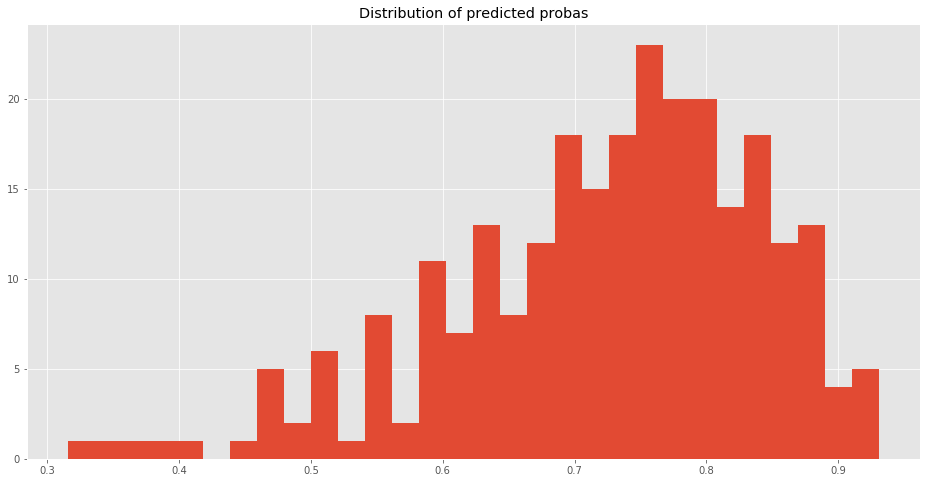

In [35]:
df3 = df2[df2["season_order"] >= 42]
games_filtered = df3

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs')

#Separate the data between a training set and a test set
whole_size = len(games_filtered.index)
train_size = int(whole_size * 0.8)
index = list(games_filtered.index)
np.random.seed(42)
np.random.shuffle(index)
train_index = index[:train_size]
test_index = index[train_size:]

train_df = games_filtered.loc[train_index]
test_df = games_filtered.loc[test_index]

#Perform the logistic regression
lr.fit(train_df[["prev_home_r","prev_away_r"]], 
       train_df["home_score"] > train_df["away_score"])

#Print the accuracy of the prediction
print(lr.score(test_df[["prev_home_r","prev_away_r"]], 
               test_df["home_score"] > test_df["away_score"]))

plt.hist(lr.predict_proba(test_df[["prev_home_r","prev_away_r"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()

<div style="text-align: justify"> The accuracy is the number of true predictions divided by the number of all the predictions. Here it is approximately 73%. The graphic is interesting. We see that most of the values are greater or equal than 1/2. It means that in the majority of cases, we predict that the team playing at home wins. This is consistent with rugby. The probability for a team to win while playing at home is approximately 75%. We would then expect such a trend in our results. We can now add some more parameters including the shapes of the teams and perform another logistic regression:  </div>

0.7279693486590039


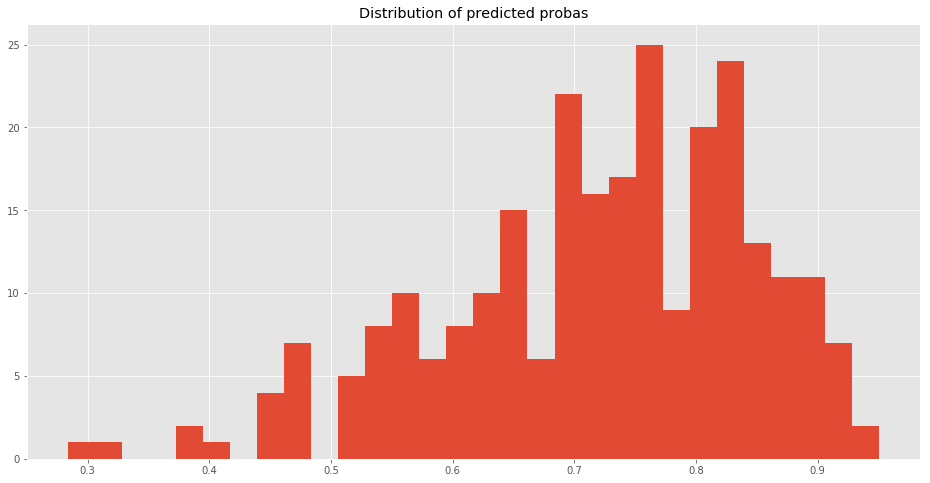

In [36]:
#Perform the logistic regression
lr.fit(train_df[["prev_home_r","prev_away_r","home_shape","away_shape"]], 
       train_df["home_score"] > train_df["away_score"])

#Print the accuracy of the prediction
print(lr.score(test_df[["prev_home_r","prev_away_r","home_shape","away_shape"]], 
               test_df["home_score"] > test_df["away_score"]))

plt.hist(lr.predict_proba(test_df[["prev_home_r","prev_away_r","home_shape","away_shape"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()

<div style="text-align: justify"> The accuracy is lower. Since the parameters of shapes depend on the Glicko rating we have variables which are correlated. It may explain that difference. Let's try the regression only with the parameters of shape:  </div>

0.735632183908046


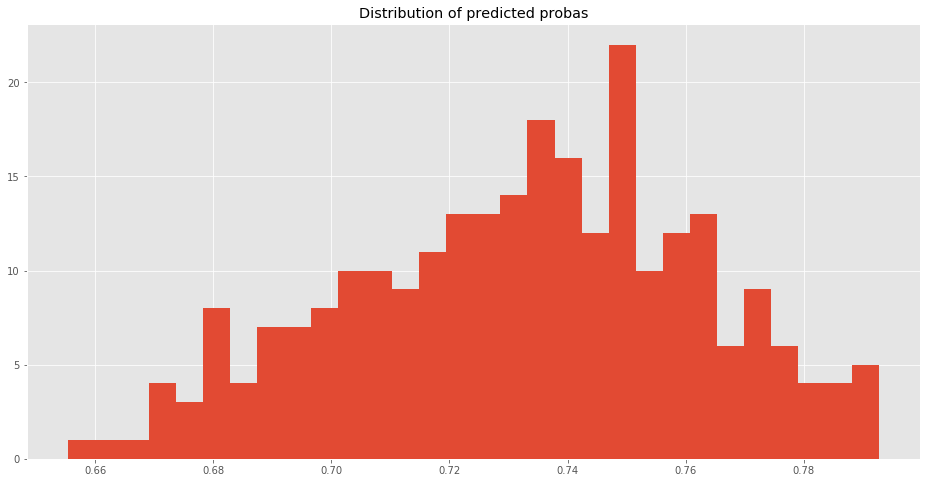

In [37]:
#Perform the logistic regression
lr.fit(train_df[["home_shape","away_shape"]], 
       train_df["home_score"] > train_df["away_score"])

#Print the accuracy of the prediction
print(lr.score(test_df[["home_shape","away_shape"]], 
               test_df["home_score"] > test_df["away_score"]))

plt.hist(lr.predict_proba(test_df[["home_shape","away_shape"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()

<div style="text-align: justify"> We have a greater accuracy. We can also see that we always predict a victory for a team playing at home. Thus, the strategy advised by that model is to always bet on the team playing at home. It is a simple strategy and we want to do better than that. So, we know that a model will be valuable only if it beats that simple strategy. Therefore, it will be valuable only if the accuracy is greater than 73.5%.</div>

<div style="text-align: justify"> In the function that inserts the ratings in the dataframe, there is an argument called exp_kernel. This argument is used to create a function that gives the shape of a team. We use a exponential kernel to define that function as seen before. In order to optimize the choice of exp_kernel, we used k-fold cross validation as follow:</div>

In [38]:
# Select the best kernel using k-fold cross validation on the training data

from sklearn.model_selection import KFold

X = np.array(train_df[["prev_home_r","prev_away_r"]])
y = np.array(train_df["home_score"] > train_df["away_score"])

kernels_vals = []
accuracies_vals = []

kfold = KFold(n_splits=5, shuffle=True)

for k, (sub_train_index, sub_test_index) in enumerate(kfold.split(X)):
    kernels = np.linspace(0.01, 1, 5)
    best_accuracy = -1
    best_kernel = -1
    for kernel in kernels:
        train_df_kernel, _, _ = Gl.glicko(train_df,exp_kernel=kernel)
        X_kernel = np.array(train_df_kernel[["home_shape","away_shape"]])
        X_bis=np.concatenate((X,X_kernel))
        X_train, X_test = X_bis[sub_train_index], X_bis[sub_test_index]
        y_train, y_test = y[sub_train_index], y[sub_test_index]
        lr.fit(X_train, y_train)
        y_pred = lr.predict_proba(X_test)[:, 1] > 0.5
        accuracy = np.sum(y_pred == y_test) / len(y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_kernel = kernel
            home_wins = np.sum(y_test) / len(y_test)
            predicted_wins = np.sum(y_pred) / len(y_pred)
    print(f"Fold {k}, accuracy {best_accuracy:.2%}, kernel {best_kernel:.5f}, home wins {home_wins:.2%}"
                  f", predicted wins {predicted_wins:.2%}")
    kernels_vals.append(best_kernel)
    accuracies_vals.append(best_accuracy)



Fold 0, accuracy 77.03%, kernel 0.01000, home wins 75.12%, predicted wins 96.17%
Fold 1, accuracy 73.68%, kernel 0.01000, home wins 72.73%, predicted wins 97.13%
Fold 2, accuracy 73.68%, kernel 0.01000, home wins 73.21%, predicted wins 96.65%
Fold 3, accuracy 77.03%, kernel 0.01000, home wins 72.73%, predicted wins 94.74%
Fold 4, accuracy 75.48%, kernel 0.01000, home wins 73.08%, predicted wins 95.67%


<div style="text-align: justify"> Since we always predict probabilities greater or equal than 1/2, the value of the kernel does not change the prediction. Thus, the algorithm gives as the best kernel the initial kernel: 0.01.</div>

***Conclusion of part I***
<div style="text-align: justify"> The results obtained when using the Glicko rating do not beat what can be done simply by betting on the home team. Therefore, we need to find new parameters. We will now present the Pi rating.</div>

## III. Pi Rating

<br>

<div style="text-align: justify"> The principle of the Pi rating is detailed in Anthony C. Constantinou and Norman E. Fenton's paper in the bibliography. What is interesting with the Pi rating is that unlike the Glicko rating, the Pi rating consists in actually two ratings: one when a team plays at home and the other when it plays away. Here is the implementation of the Pi rating in Python. Similarly to how we proceeded with the Glicko rating, we used a class to implement the rating.</div>

In [41]:
class Pi_rating:
    
    def __init__(self, c=None, l=None, gamma=None):
        self.c = c
        self.l = l
        self.gamma = gamma
    
    def _aux_phi(self,e):
        return self.c*np.log(e+1)
    
    def _aux_predict_difference(self,r):
        r2=np.abs(r)
        g_pred = np.exp(r2/self.c) - 1
        if r>0:
            return g_pred
        else:
            return (-g_pred)
    
    def _aux_error(self,g,r):
        g_pred = self._aux_predict_difference(r)
        return np.abs(g_pred-g)
    
    def pi_rating(self, games, init_rating=None):
        
        if self.c is None or self.l is None or self.gamma is None:
            raise ValueError("c, l or gamma attribute has not been instantiated.")
        games = games.sort_values(["season", "season_order"])
        teams = set(games["home_team"]) | set(games["away_team"])
        team_home_ratings = {}
        team_away_ratings = {}
        if init_rating is None:
            for team in teams:
                team_home_ratings[team] = 0
                team_away_ratings[team] = 0
        else:
            for team in teams:
               
            
                if team in init_rating:
                    team_ratings[team] = init_rating[team]
                else:
                    team_ratings[team] = 0
        # Process
        for games_index, row in games.iterrows():
            home_team = row["home_team"]
            away_team = row["away_team"]
            # retrieve current values
            rhh = team_home_ratings[home_team]
            rha = team_away_ratings[home_team]
            rah = team_home_ratings[away_team]
            raa = team_away_ratings[away_team]
            # Calculate new values
            g = row["home_score"] - row["away_score"]
            g_pred_home_team = self._aux_predict_difference(rhh)
            g_pred_away_team = self._aux_predict_difference(raa)
            g_pred = g_pred_home_team - g_pred_away_team
            e = np.abs(g - g_pred)
            p = self._aux_phi(e)
            # Compute
            if g_pred < g:
                new_rhh = rhh + p*self.l
                new_rha = rha + (new_rhh - rhh)*self.gamma
                new_raa = raa - p*self.l
                new_rah = rah + (new_raa - raa)*self.gamma
            else :
                new_rhh = rhh - p*self.l
                new_rha = rha + (new_rhh - rhh)*self.gamma
                new_raa = raa + p*self.l
                new_rah = rah + (new_raa - raa)*self.gamma
            # Update
            # ----- Store result
            games.loc[games_index, "home_r_at_home"] = new_rhh
            games.loc[games_index, "home_r_away"] = new_rha
            games.loc[games_index, "away_r_at_home"] = new_rah
            games.loc[games_index, "away_r_away"] = new_raa
            games.loc[games_index, "prev_home_r_at_home"] = rhh
            games.loc[games_index, "prev_home_r_away"] = rha
            games.loc[games_index, "prev_away_r_at_home"] = rah
            games.loc[games_index, "prev_away_r_away"] = raa
            # ----- Update function helper variables
            team_home_ratings[home_team] = new_rhh
            team_away_ratings[home_team] = new_rha
            team_home_ratings[away_team] = new_rah
            team_away_ratings[away_team] = new_raa
        return games, team_home_ratings, team_away_ratings

    # New parameter: percentage of away wins among all the wins
    
    def awayshape(self, games):
        games = games.sort_values(["season", "season_order"])
        teams = set(games["home_team"]) | set(games["away_team"])
        prev_number_away_wins = {}
        prev_number_wins = {}
       
    
        prev_score = {}
        for team in teams:
            prev_number_away_wins[team] = 1
            prev_number_wins[team] = 1
            prev_score[team] = 0
        for games_index, row in games.iterrows():
            home_team = row["home_team"]
            away_team = row["away_team"]
            h1 = prev_number_away_wins[home_team]
            h2 = prev_number_wins[home_team]
            a1 = prev_number_away_wins[away_team]
            a2 = prev_number_wins[away_team]
            rh = h1/h2
            ra = a1/a2
            home_s = prev_score[home_team]
            away_s = prev_score[away_team]
            games.loc[games_index, "home_awayshape"] = rh
            games.loc[games_index, "away_awayshape"] = ra
            games.loc[games_index, "home_number_of_wins"] = h2
            games.loc[games_index, "away_number_of_wins"] = a2
            games.loc[games_index, "home_number_of_wins_away"] = h1
            games.loc[games_index, "away_number_of_wins_away"] = a1
            games.loc[games_index, "home_prev_score"] = home_s
            games.loc[games_index, "away_prev_score"] = away_s
            if row["home_score"] < row["away_score"]:
                prev_number_away_wins[away_team]+= 1
                prev_number_wins[away_team]+= 1
            elif row["home_score"] > row ["away_score"]:
                prev_number_wins[home_team]+= 1
            prev_score[home_team] = row["home_score"]
            prev_score[away_team] = row["away_score"]
        return games
    
    
Pr=Pi_rating()
import numpy as np
from utils.gamesloader import Top14Loader
df = Top14Loader.get_consolidated_games()
c = 3
l = 0.035
gamma = 0.7
Pr.__init__(c,l,gamma)
df2, _, _ =Pr.pi_rating(df)
df2[["prev_home_r_at_home"]]

prev_home_r_at_home
185              0.000000
184              0.000000
183              0.000000
182              0.000000
181              0.000000
180              0.000000
179              0.000000
178             -0.161496
177              0.050946
176             -0.227192
175              0.169240
174             -0.269320
173              0.000000
172              0.188524
171              0.055172
170             -0.199312
169             -0.056362
168              0.086291
167             -0.465112
166             -0.463605
165              0.204804
164              0.352826
163              0.104217
162              0.425343
161             -0.233350
160             -0.273678
159             -0.165990
158              0.065382
157              0.507582
156             -0.117940
...                   ...
1524            -3.527182
1523             8.197146
1522             6.197598
1521             8.980815
1520            -2.902486
1519             1.874495
1518             5.855279
1517             1.541813
1516             5.687794
1515             7.261670
1514             8.850358
1513            -2.581291
1512             3.435471
1511             8.419839
1510            -3.036092
1509             4.404457
1508             7.467189
1507             1.345182
1506             6.368993
1505             1.694424
1504             5.543615
1503             5.999609
1502             6.526237
1501             1.250518
1500            -1.709351
1499             8.998865
1498             7.136575
1497             8.549162
1496             6.659264
1495             8.795756

[1683 rows x 1 columns]

<div style="text-align: justify"> We notice that whereas the magnitude of the values of the Glicko rating was 100, the magnitude for the Pi rating is 10. </div>

<div style="text-align: justify"> We also added a function called awayshape which tells how a team is performing while playing away. Unlike the previous shape parameters created, this one does not rely on the Glicko rating nor on the Pi rating. We also added the number of wins away and the number of wins for each team as well as the score of the team at the previous game as we think these variables could be interesting for the model. We consider how a team performs away because it is more difficult to win a game away in rugby than at home. </div>

<div style="text-align: justify"> Let's now predict the games with the Pi rating: </div>

0.7394636015325671


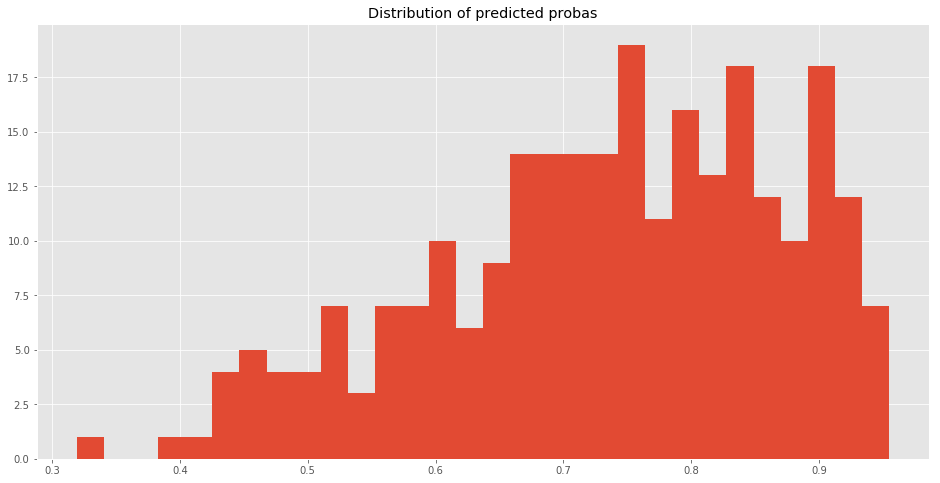

In [44]:
df3 = Pr.awayshape(df2)
df4 = df3[df3["season_order"] >= 42]
games_filtered = df4
train_df = games_filtered.loc[train_index]
test_df = games_filtered.loc[test_index]

lr.fit(train_df[["prev_home_r_at_home","prev_away_r_away",]],
       train_df["home_score"] > train_df["away_score"])
print(lr.score(test_df[["prev_home_r_at_home","prev_away_r_away"]],
               test_df["home_score"] > test_df["away_score"]))

plt.hist(lr.predict_proba(test_df[["prev_home_r_at_home","prev_away_r_away"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()

<div style="text-align: justify"> The accuracy is better. Let's try adding the awayshape variable:</div>

0.7394636015325671


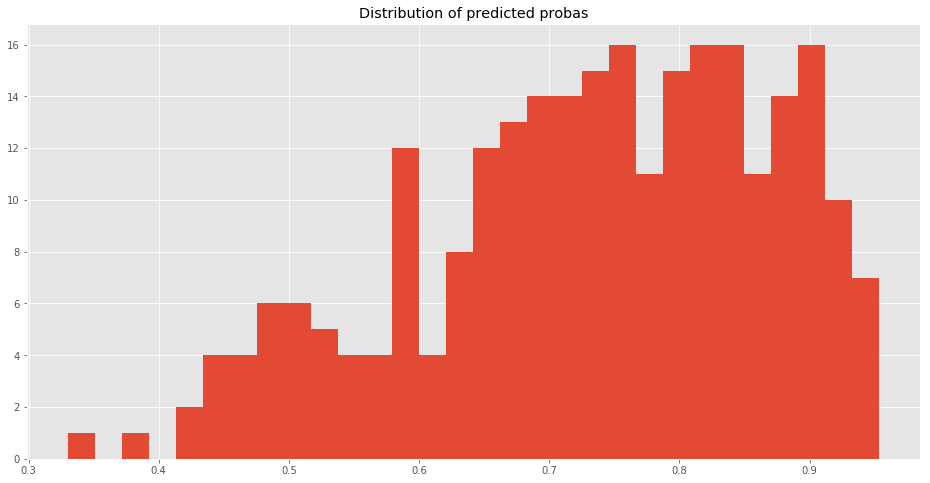

In [45]:
lr.fit(train_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape",
                 "away_awayshape"]],
       train_df["home_score"] > train_df["away_score"])
print(lr.score(test_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape",
                        "away_awayshape"]],
               test_df["home_score"] > test_df["away_score"]))

plt.hist(lr.predict_proba(test_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape",
                                   "away_awayshape"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()

<div style="text-align: justify"> Even if the distribution of probabilities does not change, the accuracy remains the same.</div>

<div style="text-align: justify"> We will now adding all the variables not correlated among themselves:</div>

0.7471264367816092


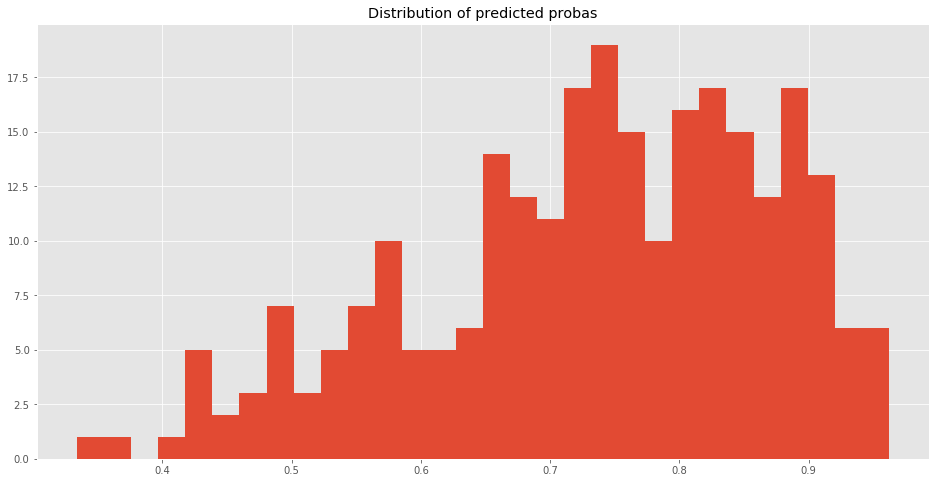

In [53]:
lr.fit(train_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape",
                 "home_prev_score","away_prev_score"]], train_df["home_score"] > train_df["away_score"])
print(lr.score(test_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape",
                        "home_prev_score","away_prev_score"]], test_df["home_score"] > test_df["away_score"]))

plt.hist(lr.predict_proba(test_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape",
                                   "home_prev_score","away_prev_score"]])[:, 1], bins=30)
plt.title("Distribution of predicted probas")
plt.show()

<div style="text-align: justify"> The results are now much better and close to 75% of accuracy. We can see that we have worse results using Lasso: </div>

In [55]:
log = LogisticRegression(penalty='l1', solver='liblinear')

log.fit(train_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape",
                 "home_prev_score","away_prev_score"]], train_df["home_score"] > train_df["away_score"])
print(log.score(test_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape",
                        "home_prev_score","away_prev_score"]], test_df["home_score"] > test_df["away_score"]))

0.735632183908046


***Conclusion of part II***
<div style="text-align: justify"> The Pi rating proved itself more efficient than the Glicko rating as we get better results and an accuracy greater than the 73.5% threshold. With all the variables we have created we will now develop our final model. </div>

## IV. Final model

<br>
<div style="text-align: justify"> We are going to combine the Glicko and the Pi rating:</div>

In [59]:
Gl=Glicko()
import numpy as np
from utils.gamesloader import Top14Loader
df = Top14Loader.get_consolidated_games()
q=np.log(10)/2000
c=60
Gl.__init__(q,c)
df2, _, _ =Gl.glicko(df,exp_kernel=0.01)

Pr=Pi_rating()
import numpy as np
from utils.gamesloader import Top14Loader
df = Top14Loader.get_consolidated_games()
c = 3
l = 0.035
gamma = 0.7
Pr.__init__(c,l,gamma)
df3,_,_=Pr.pi_rating(df2)
df4 = Pr.awayshape(df3)

games_filtered = df4[df4["season_order"] >= 42]

train_df = games_filtered.loc[train_index]
test_df = games_filtered.loc[test_index]

lr.fit(train_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape",
                 "home_prev_score","away_prev_score","prev_home_r",
                 "prev_away_r"]], train_df["home_score"] > train_df["away_score"])
print(lr.score(test_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape",
                        "home_prev_score","away_prev_score","prev_home_r",
                        "prev_away_r"]], test_df["home_score"] > test_df["away_score"]))

0.735632183908046


The accuracy is worse. Thus, for our final model, we decide to keep the following parameters:
    - Home team's home Pi rating
    - Away team's away Pi rating
    - Home team's performances when playing away ("home_awayshape")
    - Home team's performances when playing away ("home_awayshape")
    - Home team's score at last game
    - Away team's score at last game
Let's try our model on the two interesting subsets: the games where the team playing at home had won and the games where the team playing at home had lost:

In [62]:
#Test on games where the home team won

test_df_home = test_df[test_df["home_score"] > test_df["away_score"]]

lr.fit(train_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape",
                 "home_prev_score","away_prev_score"]], train_df["home_score"] > train_df["away_score"])
print(lr.score(test_df_home[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape",
                        "home_prev_score","away_prev_score"]], test_df_home["home_score"] > test_df_home["away_score"]))

0.9583333333333334


In [63]:
#Test on games where the home team lost

test_df_away = test_df[test_df["away_score"] > test_df["home_score"]]

lr.fit(train_df[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape",
                 "home_prev_score","away_prev_score"]], train_df["home_score"] > train_df["away_score"])
print(lr.score(test_df_away[["prev_home_r_at_home","prev_away_r_away","home_awayshape","away_awayshape",
                        "home_prev_score","away_prev_score"]], test_df_away["home_score"] > test_df_away["away_score"]))

0.1694915254237288


<div style="text-align: justify"> Our model is very precise on the games where it turned out that the team playing at home won. However the accuracy decreases a lot for games where the team playing at home lost.</div>

## Conclusion

<br>
<div style="text-align: justify"> Our final model performs very well for games where the home team won (accuracy: 96%) but not when the home team lost (17%). Nevertheless, the model enables us to make some predictions with a an accuracy of almost 75% which is better than the accuracy of a strategy which would just consist in betting on the team playing at home. </div>

What can be done to increase the accuracy:
    - Optimizing the three parameters of the Pi rating
    - Using another algorithm, SVM for instance
    - Creating other explanatory variables
<div style="text-align: justify"> However, it might be difficult to increase the accuracy because we are predicting rugby. Therefore, it could be interesting to build a model for other sports which are thoughts to be more predictible (such as Tennis) and see what accuracy we will have.</div>

<div style="text-align: justify"> Anyway, the next step for us is to use our model to make predictions on the French rugby championship. As this year's season is coming to an end we will have to wait for next year and try the profitability of our model of the new season.</div>
<br>
<br>


## Appendix

<br>
<div style="text-align: justify"> Here is the raw data looks under a json format. We took for instance the 2009-2010 season:</div>

<div style="text-align: justify"> In that document the numbers refer to precise games. For instance the number "53743" refers to a game also available under a json format:</div>

## Bibliography

As well as the two papers presented after, we used the documentation of Python's scientific libraries.

*For the Glicko rating:*
Glickman, M.E. The Glicko system. Harvard University

*For the Pi rating:*
Constantinou, A.C., Fenton, N.E. (2012) Determining the level of ability of football teams by dynamic ratings based on the relative discrepancies in scores between adversaries. Queen Mary, University of London